[Writing LeNet5 from Scratch in PyTorch](https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/)

---

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
from torch.utils.data import Dataset

#For testing later
import cv2 as cv
import os
from matplotlib import pyplot as plt
import numpy as np
import imutils
import csv
from PIL import Image

In [40]:
#Global var
batch_size = 64
num_classes = 13
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

label_names={
    0:"black_bishop",
    1:"black_king",
    2:"black_knight",
    3:"black_pawn",
    4:"black_queen",
    5:"black_rook",
    6:"empty",
    7:"white_bishop",
    8:"white_king",
    9:"white_knight",
    10:"white_pawn",
    11:"white_queen",
    12:"white_rook",
}

In [3]:
from torchvision.io import read_image

class ChessPieceDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = torch.tensor(list(self.img_labels.iloc[idx, 1:]))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [46]:
#Loading the dataset and preprocessing
train_dataset = ChessPieceDataset("overhead_pieces/train/_classes.csv","overhead_pieces/train")

test_dataset = ChessPieceDataset("overhead_pieces/test/_classes.csv","overhead_pieces/test")

valid_dataset = ChessPieceDataset("overhead_pieces/valid/_classes.csv","overhead_pieces/valid")

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [44]:
#Defining the CNN
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(3136, 64)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out
    

LeNet5(10)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=64, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [183]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# #this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [184]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device).to(torch.float)
        labels = labels.to(device).to(torch.float)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/20], Step [1/79], Loss: 2.5724
Epoch [1/20], Step [2/79], Loss: 2.6079
Epoch [1/20], Step [3/79], Loss: 2.5204
Epoch [1/20], Step [4/79], Loss: 2.4001
Epoch [1/20], Step [5/79], Loss: 2.5483
Epoch [1/20], Step [6/79], Loss: 2.3410
Epoch [1/20], Step [7/79], Loss: 2.3378
Epoch [1/20], Step [8/79], Loss: 2.3740
Epoch [1/20], Step [9/79], Loss: 2.3629
Epoch [1/20], Step [10/79], Loss: 2.2391
Epoch [1/20], Step [11/79], Loss: 2.1942
Epoch [1/20], Step [12/79], Loss: 2.0867
Epoch [1/20], Step [13/79], Loss: 2.1418
Epoch [1/20], Step [14/79], Loss: 2.1134
Epoch [1/20], Step [15/79], Loss: 2.0280
Epoch [1/20], Step [16/79], Loss: 2.1548
Epoch [1/20], Step [17/79], Loss: 1.9802
Epoch [1/20], Step [18/79], Loss: 2.0075
Epoch [1/20], Step [19/79], Loss: 2.1266
Epoch [1/20], Step [20/79], Loss: 2.0260
Epoch [1/20], Step [21/79], Loss: 2.0025
Epoch [1/20], Step [22/79], Loss: 2.0284
Epoch [1/20], Step [23/79], Loss: 1.8629
Epoch [1/20], Step [24/79], Loss: 1.8676
Epoch [1/20], Step [25/79

In [185]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device).to(torch.float)

        labels = torch.argmax(labels.to(device).to(torch.float), dim=1)
        outputs = model(images)

        predicted = torch.argmax(outputs.data, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network: {} %'.format(100 * correct / total))
    
    #Save the thing
    torch.save(model.state_dict(), "model.pt")

Accuracy of the network: 52.30125523012552 %


In [53]:
#Sanity check
with torch.no_grad():
    model = LeNet5(num_classes).to(device)
    model.load_state_dict(torch.load("model.pt"))
    model.eval()

    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device).to(torch.float)

        labels = torch.argmax(labels.to(device).to(torch.float), dim=1)
        outputs = model(images)

        predicted = torch.argmax(outputs.data, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network: {} %'.format(100 * correct / total))



Accuracy of the network: 50.42016806722689 %


Testing My Own Data

---

In [149]:
#Utils
def resize(imgs, size=100):
    imgs = list(imgs)
    for i in range(len(imgs)):
        img = imgs[i]
        imgs[i] = cv.resize(img, (size,size))

    return np.array(imgs)

def splitAndSwap(imgs):
    imgs = list(imgs)
    for i in range(len(imgs)):
        img = imgs[i]
        temp = list(cv.split(img))
        _ = temp[2].copy()
        temp[2] = temp[0].copy()
        temp[0] = _ 

        imgs[i] = temp
    
    return np.array(imgs)

torch.Size([1, 3, 70, 70])

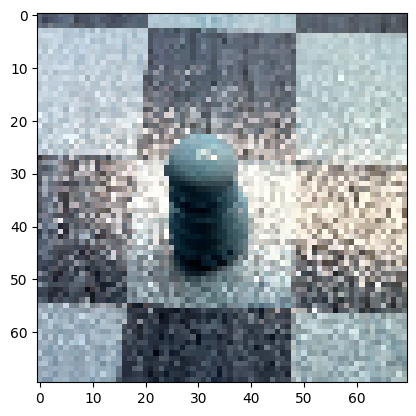

In [150]:
#The data
img = cv.imread("orig_pieces/image4.jpg")
imgs = resize(np.array([img]),70)

plt.imshow(imgs[0])

temp = splitAndSwap(imgs)

resized = torch.from_numpy(temp)
resized.shape

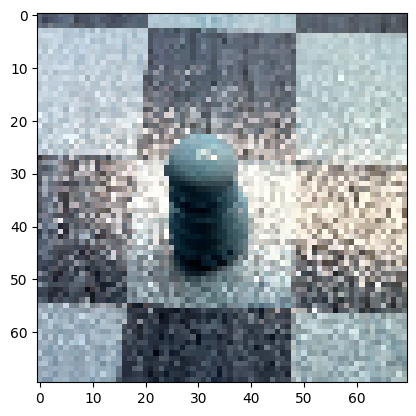

In [151]:
#Sanity check
temp = np.array(resized)
_ = temp[0][2].copy()
temp[0][2] = temp[0][0].copy()
temp[0][0] = _ 

temp = np.array(temp).squeeze()

b,g,r = temp
t = cv.merge((b,g,r))

plt.imshow(t)

In [154]:
img = resized.to(device).to(torch.float)
labels = 10

outputs = model(img)
print(outputs.shape)
predicted = torch.argmax(outputs.data, 1)

label_names[predicted.item()], label_names[labels]

torch.Size([1, 13])


('black_bishop', 'white_pawn')